# Fully Dynamic k-center Clustering

## Parsing

This section has to be runned only once; its role is to parse the data and create a .hdf5 dataset with three fields: one for the timestamp, one for the latitude, one for the longitude. We will use this file in the following sections.

In [1]:
import h5py
def parse_input(path):
    dataset = h5py.File("dataset.hdf5", "w")
    timestamps = dataset.create_dataset("timestamps", (1000000,), dtype='i')
    latitudes = dataset.create_dataset("latitudes", (1000000,), dtype='f')
    longitudes = dataset.create_dataset("longitudes", (1000000,), dtype='f')
    f = open(path,'r')
    for i, line in enumerate(f):
        line = line.split()
        timestamps[i] = int(line[0])
        latitudes[i] = float(line[1])
        longitudes[i] = float(line[2])
    dataset.close()

In [2]:
parse_input('dataset/twitter_1000000.txt')

## Data visualization

Just to check that our geographical data look relevant, i.e that it "coincides" with a world map (at least on the part of the world that are conneted to Twitter!)

In [1]:
import h5py
f = h5py.File('dataset.hdf5', 'r')

In [2]:
timestamps = f['timestamps']
latitudes = f['latitudes']
longitudes = f['longitudes']
for i in range(0, 10):
    print(latitudes[i], longitudes[i])

(0.37526667, 52.263897)
(121.03524, 14.651666)
(-61.205151, -27.213259)
(101.69062, 3.0527644)
(12.3267, 45.438599)
(135.5036, 34.680218)
(139.75256, 35.654442)
(139.77625, 35.713306)
(4.0833302, 48.299999)
(103.85493, 1.300463)


In [3]:
dataset = list(zip(latitudes, longitudes))
for i in range(0, 10):
    print(dataset[i])

(0.37526667, 52.263897)
(121.03524, 14.651666)
(-61.205151, -27.213259)
(101.69062, 3.0527644)
(12.3267, 45.438599)
(135.5036, 34.680218)
(139.75256, 35.654442)
(139.77625, 35.713306)
(4.0833302, 48.299999)
(103.85493, 1.300463)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
sample_dataset = random.sample(dataset, 4000)
sample_latitudes = [sample[0] for sample in sample_dataset]
sample_longitudes = [sample[1] for sample in sample_dataset]

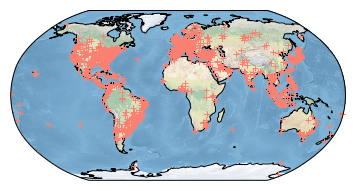

'\nplt.scatter(sample_latitudes, sample_longitudes, s=7)\nplt.xlabel("Latitude")\nplt.ylabel("Longitude")\nplt.show()'

In [7]:
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.stock_img()
ax.coastlines()
plt.plot(sample_latitudes, sample_longitudes, '+', transform=ccrs.PlateCarree(), color='salmon')
plt.show()

## Basic static algorithm 

### Definition of the metric

Here we define a metric that is consistent with the data we deal with : the Haversine distance, which is basically the number of kilometers between two points located with their GPS coordinates.

In [8]:
import math

def Haversine(point, neighbor):
    lat1 = point[0]
    lat2 = neighbor[0]
    lon1 = point[1]
    lon2 = neighbor[1]
    R=6371000                             
    phi_1=math.radians(lat1)
    phi_2=math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi/2.0)**2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda/2.0)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        
    return R*c/1000

In [9]:
Haversine(dataset[0], dataset[1])
Haversine(dataset[0], dataset[2])

9483.092886325172

### Computation of the Betas

In [10]:
import numpy as np

id_to_coords = {i : point for i, point in enumerate(dataset)}

def max_and_min_dists(id_to_coords, sample):
    max_dist = 0
    min_dist = np.infty
    n = len(sample)
    for i in range(0, n-1):
        point = id_to_coords[sample[i]]
        for j in range(i+1, n):
            neighbor = id_to_coords[sample[j]]
            print(point, neighbor)
            distance = Haversine(point, neighbor)
            if distance > max_dist:
                max_dist = distance
            if distance < min_dist:
                min_dist = distance
    return max_dist, min_dist

In [11]:
"""maxima, minima = [], []
for i in range(0, 10):
    print('computing on sample ', i)
    sample = random.sample(list(range(0, 1000000)), 5000)
    maximum, minimum = max_and_min_dists(id_to_coords, sample)
    maxima.append(maximum)
    minima.append(minimum)
print(max(maxima))
print(min(minima))"""

"maxima, minima = [], []\nfor i in range(0, 10):\n    print('computing on sample ', i)\n    sample = random.sample(list(range(0, 1000000)), 5000)\n    maximum, minimum = max_and_min_dists(id_to_coords, sample)\n    maxima.append(maximum)\n    minima.append(minimum)\nprint(max(maxima))\nprint(min(minima))"

3

In [16]:
def compute_betas(d_min, d_max, eps):
    betas = []
    i_min = int(math.ceil(math.log(d_min)/math.log(1+eps)))
    i_max = int(math.floor(math.log(d_max)/math.log(1+eps)))
    for i in range(i_min, i_max+1):
        betas.append((1+eps)**i)
    return betas

In [17]:
betas = compute_betas(1, 20000, 0.5)
print('minimum beta : ', betas[0])
print('maximum beta : ', betas[-1])
print('number of betas : ', len(betas))

(0, 24)
('minimum beta : ', 1.0)
('maximum beta : ', 16834.112196028233)
('number of betas : ', 25)


### Static clustering

In [46]:
def build_cluster(center_id, beta, dataset_ids, clusters):
    center = id_to_coords[center_id]
    clusters[center_id] = center_id
    i = 0
    print('building new cluster...')
    while True:
        if i >= len(dataset_ids):
            break      
        point_id = dataset_ids[i]
        if point_id != center_id:
            distance = Haversine(center, id_to_coords[point_id])
            if distance <= 2*beta:
                clusters[point_id] = (center_id)
                dataset_ids.remove(point_id)
            else:
                i += 1
        else:
            dataset_ids.remove(point_id)
    print(str(len(dataset_ids)) +' points remain to be affected')
    return dataset_ids, clusters

In [47]:
from copy import deepcopy

def build_beta_clustering(k, beta, dataset_ids):
    clusters = {point_id : -1 for point_id in dataset_ids}
    d = deepcopy(dataset_ids)
    for i in range(0, k):
        if not d:
            break
        center_id = random.choice(dataset_ids)
        d, clusters = build_cluster(center_id, beta, d, clusters)
    return clusters

In [48]:
def build_whole_clustering(k, betas, dataset_ids):
    clustering = {}
    for beta in betas:
        print('computing for beta = ', beta)
        clusters = build_beta_clustering(k, beta, dataset_ids)
        clustering[beta] = clusters
    return clustering

In [182]:
clustering = build_whole_clustering(9, [1500], random.sample(list(range(0, 1000000)), 20000))

('computing for beta = ', 1500)
building new cluster...
17516 points remain to be affected
building new cluster...
14995 points remain to be affected
building new cluster...
11962 points remain to be affected
building new cluster...
6871 points remain to be affected
building new cluster...
4940 points remain to be affected
building new cluster...
3727 points remain to be affected
building new cluster...
3200 points remain to be affected
building new cluster...
3043 points remain to be affected
building new cluster...
3043 points remain to be affected


In [183]:
def plot_cluster_sizes(beta, clustering):
    clusters = clustering[beta]
    counts = defaultdict(int)
    for point_id, center_id in clusters.items():
        counts[center_id] += 1
    plt.bar(np.arange(len(counts.keys())), counts.values())
    plt.ylabel('Size')
    plt.xlabel('Clusters')
    plt.show()

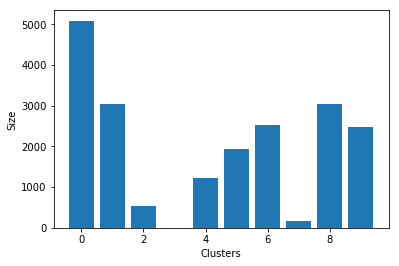

In [186]:
plot_cluster_sizes(1500, clustering)

In [187]:
def plot_clusters_on_map(clusters):
    centers_ids = list(set(clusters.values()))
    if -1 in centers_ids:
        centers_ids.remove(-1)
    col = ['salmon', 'plum', 'lime', 'lavender', 'goldenrod', 'aquamarine', 'orangered', 'darkgreen', 'sienna', 'navy', 'crimson' ] 
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()
    ax.stock_img()
    ax.coastlines()
    for center_id in centers_ids:
        affected_points = [point_id for point_id, c in clusters.items() if c == center_id]
        affected_points = random.sample(affected_points, min(100, len(affected_points)))
        latitudes = [id_to_coords[i][0] for i in affected_points]
        longitudes = [id_to_coords[i][1] for i in affected_points]
        c = col[centers_ids.index(center_id)]
        plt.plot(latitudes, longitudes, '+', transform=ccrs.PlateCarree(), color=c)
    plt.show()

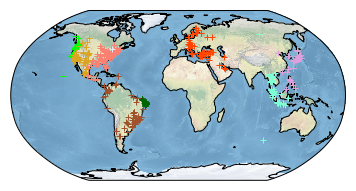

In [189]:
plot_clusters_on_map(clustering[1500])

### Dynamic clustering

In [190]:
def insertion(k, point_id, clustering):
    for beta, beta_clustering in clustering.items():
        centers_ids = list(set(beta_clustering.values()))
        if -1 in centers_ids:
            centers_ids.remove(-1)
        found = 0
        for center_id in centers_ids:
            center = id_to_coords[center_id]
            point = id_to_coords[point_id]
            if Haversine(center, point) <= 2*beta:
                beta_clustering[point_id] = center_id
                found = 1
                break
        if found == 0:
            if len(centers_ids) < k:
                beta_clustering[point_id] = point_id
            else:
                beta_clustering[point_id] = -1
    return clustering

In [200]:
clustering = build_whole_clustering(100, [1000], list(range(0, 100)))
new_points = random.sample(list(range(500, 1000000)), 20)
for new_point in new_points:
    print('new point to be added : ' + str(new_point))
    clustering = insertion(100, new_point, clustering)
    print('length of the new dataset : ' + str(len(clustering[1000].values())))
    n_clusters = len(set(clustering[1000].values()))
    print('number of clusters : ' + str(n_clusters))
    center_id = clustering[1000][new_point]
    print('center associated to the new point : ' + str(center_id))
    if center_id != -1:
        new_point = id_to_coords[new_point]
        center = id_to_coords[center_id]
        print('distance between the new point and its center : ' +str(Haversine(center, new_point)))
    print('')


('computing for beta = ', 1000)
building new cluster...
89 points remain to be affected
building new cluster...
86 points remain to be affected
building new cluster...
66 points remain to be affected
building new cluster...
54 points remain to be affected
building new cluster...
49 points remain to be affected
building new cluster...
49 points remain to be affected
building new cluster...
49 points remain to be affected
building new cluster...
42 points remain to be affected
building new cluster...
40 points remain to be affected
building new cluster...
40 points remain to be affected
building new cluster...
40 points remain to be affected
building new cluster...
40 points remain to be affected
building new cluster...
38 points remain to be affected
building new cluster...
38 points remain to be affected
building new cluster...
38 points remain to be affected
building new cluster...
36 points remain to be affected
building new cluster...
11 points remain to be affected
building new clu